# Applying our methods to CERN ghost track data

### Imports

In [5]:
#%pip install matplotlib numpy qiskit scipy pandas qiskit_machine_learning natsort tqdm

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import StatePreparation

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
algorithm_globals.random_seed = 0
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import DensityMatrix
from functools import reduce
from sympy import Matrix
from sympy import sqrt as special_sqrt
from qiskit import *
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import Operator

import os
from natsort import natsorted
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


## Loading data

Label 1 represents the inlier class (regular tracks), label -1 the outlier class (ghost tracks).

In [7]:
# load all json files in cern_data folder
full_cern_data = []
for file in natsorted(os.listdir('cern_data')):
    if file.endswith('.json'):
        df = pd.read_json('cern_data/' + file)
        full_cern_data.append(df)

full_cern_data = pd.concat(full_cern_data, ignore_index=True)
# replace 1 (ghost) with -1 (outlier) and 0 (regular) with 1 (inlier)
full_cern_data['is_ghost'] = full_cern_data['is_ghost'].replace(1, -1).replace(0, 1)
full_cern_data

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z
0,37.042889,1,2.744781,29,22,0.000093,-0.032356,-0.026533,0.032351,-0.039451,2.051071
1,12.333838,1,505.177429,21,6,-0.000100,-0.020835,-0.022025,-1.026810,0.971350,124.333954
2,11.791684,1,1.248908,24,12,0.000113,-0.008289,-0.035582,-0.032666,0.007609,84.878311
3,22.339798,1,3893.681641,26,16,-0.000053,-0.004296,-0.019615,0.003717,-0.000814,-109.656128
4,19.041876,1,2.024810,25,14,0.000094,-0.007948,-0.046065,0.069844,-0.012051,84.299057
...,...,...,...,...,...,...,...,...,...,...,...
18320,21.877516,1,1.353087,31,26,-0.000246,-0.003892,0.094137,-0.010576,-0.000436,-133.640045
18321,17.455692,1,0.945140,22,8,-0.000223,-0.170432,-0.096830,0.027389,-0.048208,94.859215
18322,2.377720,1,1.130440,20,6,-0.000157,-0.092891,-0.061437,0.007144,-0.010802,94.624451
18323,7.393714,1,10.609664,26,18,-0.000206,0.122870,-0.017398,0.016633,0.117464,-32.473801


In [8]:
full_cern_data['is_ghost'].value_counts()

 1    17705
-1      620
Name: is_ghost, dtype: int64

In [9]:
full_cern_data[full_cern_data['is_ghost'] == -1]

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z
114,6.736708,-1,2.013437,17,4,-0.000317,0.156288,-0.067397,0.011041,0.025599,196.992310
122,10.666078,-1,0.258542,21,8,-0.000028,-0.020742,-0.000281,-0.000607,0.044702,9.808350
123,91.954224,-1,41.465874,21,8,-0.000029,-0.020258,-0.000281,-0.000660,0.047713,-1.533783
124,7.582039,-1,1.203741,21,8,-0.000029,-0.019606,-0.000397,-0.000422,0.020831,9.954773
146,23.850941,-1,0.210660,29,24,0.000157,-0.034494,0.020627,-0.011212,-0.018750,-30.769402
...,...,...,...,...,...,...,...,...,...,...,...
18081,14.100121,-1,6.466623,26,18,-0.000182,0.086158,-0.034164,0.022217,0.056031,-27.052513
18150,210.464294,-1,7.795339,24,14,-0.000118,0.018131,0.093354,-0.075147,0.014596,-13.119804
18261,4.791725,-1,4.774308,17,4,0.000014,-0.001622,0.015018,-0.071725,-0.007744,109.908081
18263,15.251548,-1,0.920522,24,12,0.000086,-0.016061,0.033375,-0.023291,-0.011209,116.459412


### Feature selection

See the [CERN Data Guide](https://docs.google.com/document/d/1EQr-oIjMbOGgLth4iChvGo2jRGnEAutgjDI_1fn2nag/edit#) for explanations of the variables and why we select the ones we do.

In [10]:
# create new column for a normalized chi squared measure
full_cern_data['chi2/dof'] = full_cern_data['chi2']/full_cern_data['ndof']

# select most important features as explained in the Data Guide
cern_data = full_cern_data[['chi2/dof', 'kalman_ip_chi2', 'nb_hits', 'is_ghost']]
cern_data

,chi2/dof,kalman_ip_chi2,nb_hits,is_ghost
0,1.683768,2.744781,29,1
1,2.055640,505.177429,21,1
2,0.982640,1.248908,24,1
3,1.396237,3893.681641,26,1
4,1.360134,2.024810,25,1
...,...,...,...,...
18320,0.841443,1.353087,31,1
18321,2.181962,0.945140,22,1
18322,0.396287,1.130440,20,1
18323,0.410762,10.609664,26,1


### Preprocessing

Standardize features (subtract mean and scale to unit variance)

In [11]:
std_cern_data = StandardScaler().fit_transform(cern_data.drop(columns=['is_ghost']))
std_cern_data = pd.DataFrame(std_cern_data, columns=cern_data.drop(columns=['is_ghost']).columns)
std_cern_data['is_ghost'] = cern_data['is_ghost']
std_cern_data

,chi2/dof,kalman_ip_chi2,nb_hits,is_ghost
0,0.041073,-0.190888,1.238320,1
1,0.117441,0.143397,-1.279191,1
2,-0.102912,-0.191883,-0.335124,1
3,-0.017975,2.397880,0.294253,1
4,-0.025389,-0.191367,-0.020435,1
...,...,...,...,...
18320,-0.131908,-0.191813,1.867697,1
18321,0.143383,-0.192085,-0.964502,1
18322,-0.223326,-0.191962,-1.593879,1
18323,-0.220353,-0.185655,0.294253,1


## Algorithm 1: QSVM

### Custom Feature Maps

In [12]:
def custom_data_map_func(x):
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return mapped
def feature_map_superfidel(x):
    # as described in 
    # https://doi.org/10.1103/PhysRevA.97.042315
    
    # Qiskit currently doesn't natively support a square root function in a parameter expression
    # So use sympy base to get the same effect
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, 
                                             np.divide(x,(1-np.square(np.column_stack(x)).trace())._call(special_sqrt)))
    return mapped

### Main algorithm

In [13]:
# First algorithm, returns trained model
def Algorithm1(X, y, reps=2, shots=1, outlier_fraction=20/210,
               entanglement="linear", num_features = 2, seed = 0, 
               supervised=False, feature_map_no = 1, data_map_no = 1,
               svm_max_iter=-1) :
    if feature_map_no == 1:
        # Define ZZFeatureMap using inputs
        if data_map_no == 1:
             feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement)
        elif data_map_no == 2:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = custom_data_map_func)
        elif data_map_no == 3:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = feature_map_superfidel)
    elif feature_map_no == 2:
        # Define ZZFeatureMap using inputs
        feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
    elif feature_map_no == 3:
        # Define ZZFeatureMap using inputs
        feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Kernel needs to be evaluated before going into the One-Class SVM
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outlier_fraction, max_iter=svm_max_iter)
    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        # TODO save to Matrix
#         print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
#         print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))
    else: 
        svm.fit(X)

        # Predict step moved
#         y_pred = svm.predict(X)
#         #TODO save to matrix
# #         print(classification_report(y, y_pred))
#         print("Accuracy: {}".format(accuracy_score(y, y_pred)))

#         print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
#         print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
#         print("Macro Recall: {}".format(recall_score(y, y_pred, average='macro')))
#         print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

#         print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

    return svm

## Sample training data

In [14]:
num_samples = 1000#len(std_cern_data)

cern_sample = std_cern_data.sample(num_samples, random_state=0)

# select input features
X = cern_sample.drop(columns=['is_ghost']) 
y = cern_sample['is_ghost']

outlier_counts = y.value_counts()
outlier_fraction = outlier_counts[-1]/outlier_counts[1]
print('Outlier fraction:', outlier_fraction)
print(outlier_counts)

Outlier fraction: 0.03734439834024896
 1    964
-1     36
Name: is_ghost, dtype: int64


## Applying Algorithm 1 to data

### Training

In the LibSVM verbose output
* `obj` refers to the optimal value of the objective function reached at convergence of the dual SVM problem (lower bound to the optimal value of the primal problem). (Dual: The objective function is minimized. Primal: The objective function is maximized.)
* `rho` relates to the size of the margins at convergence and is the bias term in the decision function.
* `nSV` and `nBSV` are number of support vectors and bounded support vectors

In [44]:
trained_svm = Algorithm1(X, y, reps=1, num_features=3, svm_max_iter=-1, outlier_fraction=outlier_fraction)

[LibSVM]*.
*
optimization finished, #iter = 1564
obj = 87.163041, rho = 4.668149
nSV = 109, nBSV = 7


**Record of Runtimes:**

(including inference)  
*num_samples, svm_max_iter, runtime, macroF1*  
100, 2, 13s  
100, 10, 21s  
100, 258(-1), 16s, 0.46  

200, 1, 1m3s, 0.24  
200, 240(-1), 1m3s, 0.57  

300, 493(-1), 2m28s, 0.53

(exluding inference)  
300, 250, 1m11  
1000, 1564, 24min40s  

```
Warning: using -h 0 may be faster
*
optimization finished, #iter = 1564
obj = 87.163041, rho = 4.668149
nSV = 109, nBSV = 7
```

### Inference

In [15]:
cern_test_sample = std_cern_data.sample(100, random_state=1)

# select input features
X_test = cern_test_sample.drop(columns=['is_ghost']) 
y_test = cern_test_sample['is_ghost']

print(y_test.value_counts())

y_pred = trained_svm.predict(X_test)

print("Macro F1: {}".format(f1_score(y_test, y_pred, average='macro')))


 1    97
-1     3
Name: is_ghost, dtype: int64


NameError: name 'trained_svm' is not defined

**Record of inference runtimes:**  
100 (trained on 300), 50s, 0.47F1  
100 (trained on 300), 50s, 0.51F1  
100 (trained on 1000), 3m7s, 0.4945F1

## Algorithm 2: VQCOCC

In [40]:
from qiskit.circuit import QuantumCircuit, Parameter
from itertools import combinations
from qibo import hamiltonians
#from qiskit.opflow import Z, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow import X as X_gate
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2
import cv2

def Quantum_Autoencoder_circuit(parameters, num_qubits, num_trash_qubits, layers, num_parameters):
    circuit = QuantumCircuit(num_qubits)
    paramidx = 0
    if (num_trash_qubits <= num_qubits/2):
        for l in range(layers):
            for idx in range(num_trash_qubits):
                for q in range(num_qubits):
                    #phase rotation
                    temp_parameter = Parameter('{}'.format(paramidx))
                    circuit.ry(temp_parameter,q)
                    circuit.assign_parameters({temp_parameter: parameters[q+idx*num_qubits+l*num_trash_qubits*num_qubits]})
                    paramidx += 1
                # CZ between trash qubits
                for i,j in combinations(range(num_qubits-num_trash_qubits,num_qubits),2):
                    circuit.cz(i,j)
                # CZ between trash and non-trash qubits
                for i in range(num_trash_qubits):
                    for j in range(i,num_qubits-num_trash_qubits,num_trash_qubits):
                        circuit.cz(num_qubits-num_trash_qubits+((idx+i)%num_trash_qubits),j)
    else :
        for l in range(layers):
            for idx in range(num_qubits-num_trash_qubits):
                for q in range(num_qubits):
                    #phase rotation
                    temp_parameter = Parameter('{}'.format(paramidx))
                    circuit.ry(temp_parameter,q)
#                     circuit.ry(parameters[q+idx*num_qubits+l*(num_qubits-num_trash_qubits)*num_qubits],q)
                    circuit.assign_parameters({temp_parameter: parameters[q+idx*num_qubits+l*(num_qubits-num_trash_qubits)*num_qubits]})
                    paramidx += 1
                # CZ between trash qubits
                for i,j in combinations(range(num_qubits-num_trash_qubits,num_qubits),2):
                    circuit.cz(i,j)
                for i in range(num_qubits-num_trash_qubits):
                    for j in range(num_qubits-num_trash_qubits+i,num_qubits,num_qubits-num_trash_qubits):
                        circuit.cz((idx+i)%(num_qubits-num_trash_qubits),j)
    for q in range(num_trash_qubits):
        temp_parameter = Parameter('{}'.format(paramidx))
        circuit.ry(temp_parameter,q)
#         circuit.ry(parameters[num_parameters-num_trash_qubits+q], num_qubits-num_trash_qubits+q)
        circuit.assign_parameters({temp_parameter: parameters[num_parameters-num_trash_qubits+q]})
        paramidx += 1
    
    return circuit

#TODO
def cost_hamiltonian(num_qubits, num_trash_qubits, outliers_fraction = 20/210):
    '''
    Hamiltonian for evaluating Hamming distance based Cost function
    '''
    num_trash_qubits = num_trash_qubits 
#     print(num_trash_qubits)
#     print(hamiltonians.Z(num_trash_qubits))
#     print(hamiltonians.Z(num_trash_qubits).matrix)

    

    m0 = hamiltonians.Z(num_trash_qubits).matrix#.numpy()
    m1 = np.eye(2 ** (num_qubits - num_trash_qubits), dtype=m0.dtype)
    ham = hamiltonians.Hamiltonian(num_qubits, np.kron(m1, m0))
#     print(0.5 * (ham + num_trash_qubits))
    
#     a = Parameter('a')
#     b = Parameter('b')
#     q = QuantumRegister(1)
#     qc = QuantumCircuit(q)
#     qc.h(q)
#     qc.rz(a, q[0])
#     qc.rx(b, q[0])
#     H = (2 * X) + Z
    return 0.5 * (ham + num_trash_qubits)

def data_encoding(X, encoding="Amplitude"):
    '''
        --------
        Args :
            dataset : Dataset for one-class classification "Handwritten" or "FMNIST"
            encoding : Data encoding method "Amplitude"(Amplitude encoding) or "FRQI"(FRQI encoding)
            idx : Index of the positive data to be trained/tested for one-class classification
        --------
        Return :
            encoded_X : train dataset with the positive data
            num_qubits : the number of qubits required for the given data encoding
    '''

    encoded_X = []

    

    if encoding == "Amplitude":
        num_qubits = 8
        for i in range(len(X)):
            X = np.asarray(X)
            vector = cv2.resize(X[i], dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            encoded_X.append(vector/np.linalg.norm(vector)) 
            
            #encoded_X.append(np.array(X[i])/np.linalg.norm(np.array(X[i])))

    elif encoding == "FRQI":
        num_qubits = 9
        for i in range(len(X)):
            X = np.asarray(X)
            vector = cv2.resize(X[i], dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            vector = np.concatenate((np.cos(np.pi/2*np.array(vector)),np.sin(np.pi/2*np.array(vector))))/8.0
            encoded_X.append(vector/np.linalg.norm(np.array(vector)))  
#         print(new_X)
#         print(X)
#     elif encoding == "FRQI":
#         nqubits = 7 # number of qubits
#         digit_pos = digit_pos/16.0
#         # Data Encoding FRQI
#         for i in range(100):
#             vector = np.concatenate((np.cos(np.pi/2*np.array(digit_pos[i])),np.sin(np.pi/2*np.array(digit_pos[i]))))/8.0
#             vector_train.append(vector/np.linalg.norm(np.array(vector)))
#         for i in range(100,170):
#             vector = np.concatenate((np.cos(np.pi/2*np.array(digit_pos[i])),np.sin(np.pi/2*np.array(digit_pos[i]))))/8.0
#             vector_test_pos.append(vector/np.linalg.norm(np.array(vector)))
#         for idx_neg in neg_list:
#             digit_neg = digits.data[np.where(digits.target == idx_neg)]/16.0
#             for i in range(70):
#                 vector = np.concatenate((np.cos(np.pi/2*np.array(digit_neg[i])),np.sin(np.pi/2*np.array(digit_neg[i]))))/8.0
#                 vector_test_neg.append(vector/np.linalg.norm(np.array(vector)))
    else:
        raise ValueError(
            "Only Amplitude and FRQI encoding is supported"
        )
    
    
    return encoded_X, num_qubits


In [41]:
import torch.optim as optim
import torch
from geneticalgorithm import geneticalgorithm as ga
class VQOCC(): 
    def __init__(self, num_qubits, num_trash_qubits, layers):
        '''
        Variational Quantum One-Class Classifier
        --------
        Args :
            num_qubits : The number of qubits
            num_trash_qubits : The number of trash qubits
            layers : The number of parameterized quantum circuit layers
        --------
        '''
        assert num_trash_qubits < num_qubits

        self.num_qubits = num_qubits
        self.num_trash_qubits = num_trash_qubits
        self.layers = layers

        if (num_trash_qubits <= num_qubits/2):
            num_parameters = num_trash_qubits * (num_qubits * layers + 1)
        else:
            num_parameters = (num_qubits-num_trash_qubits)*num_qubits*layers + num_trash_qubits

        self.num_parameters = num_parameters
        self.parameters = np.random.uniform(low=0.0, high=1.0, size=(num_parameters,))
        self.circuit = Quantum_Autoencoder_circuit(self.parameters, num_qubits, num_trash_qubits, layers, num_parameters)
     
    def function(self, parameters):
        circuit_copy = self.circuit.copy()

        circuit_copy.assign_parameters(parameters, inplace=True)

    #             print(parameters)
        batch_index = np.random.randint(0, len(self.X), (self.batch_size,))
        vector_batch = [self.X[i] for i in batch_index]
        temp_loss = 0
        for i in range(self.batch_size):
    #                 circuit_copy = circuit.copy()
    #             for i in range(len(X)-1):
            start_qc = QuantumCircuit(8)
#             start_qc.initialize(self.X[i], start_qc.qubits[0])
#             start_qc.initialize(self.X[i], start_qc.qubits[1])
            start_qc.initialize(self.X[i])
    
            qc = start_qc + circuit_copy
            qc.save_statevector('test1')
            qc.measure_all()
            qc.save_statevector('test2')

            sim = Aer.get_backend('aer_simulator')
            qobj = assemble(qc)
            job = sim.run(qobj,shots=100)
            result = job.result()
            data = result.data()
            resulting_state = data['test2'].data
            temp_loss += self.ham.expectation(resulting_state)/(self.num_trash_qubits*self.batch_size)
        return temp_loss
    def train(self,X,lr=0.1,n_epochs=150,batch_size=10,verbose_loss=False):
        '''
        --------
        Args :
            X :  dataset
            lr : Learning rate
            n_epochs : The number of training epochs
            batch_size : The size of batch for Training
            verbose_loss : returning the loss history
        --------
        '''
#         criterion = nn.CrossEntropyLoss()
#         parameter_tensor = [torch.tensor(self.parameters, requires_grad=True)]
#         optimizer = optim.Adam(parameter_tensor , lr=lr)
#         print(parameter_tensor[0].detach().numpy())

        parameters = self.parameters
        best_parameters = self.parameters
        loss_history = []
        num_trash_qubits = self.num_trash_qubits
        self.batch_size = batch_size
        circuit = self.circuit.copy()
        self.X = X
        self.ham = cost_hamiltonian(self.num_qubits,num_trash_qubits)
#         print(type(ham))
        loss = 1
#         for e in range(n_epochs):
#             # Training Quantum circuit with loss functions evaluated from Hamiltonian
#             # using automatic differentiation
# #             print(len(parameters))
#             circuit_copy = circuit.copy()
    
# #             circuit_copy.assign_parameters(parameter_tensor[0].detach().numpy(), inplace=True)
#             circuit_copy.assign_parameters(parameters, inplace=True)

# #             print(parameters)
#             batch_index = np.random.randint(0, len(X), (batch_size,))
#             vector_batch = [X[i] for i in batch_index]
#             temp_loss = 0
#             for i in range(batch_size):
# #                 circuit_copy = circuit.copy()
# #             for i in range(len(X)-1):
#                 start_qc = QuantumCircuit(2)
#                 start_qc.initialize(encoded_X[i], start_qc.qubits[0])
#                 start_qc.initialize(encoded_X[i], start_qc.qubits[1])
#                 qc = start_qc + circuit_copy
#                 qc.save_statevector('test1')
#                 qc.measure_all()
#                 qc.save_statevector('test2')

#                 sim = Aer.get_backend('aer_simulator')
#                 qobj = assemble(qc)
#                 job = sim.run(qobj,shots=1024)
#                 result = job.result()
#                 data = result.data()
#                 resulting_state = data['test1'].data
#                 temp_loss += self.ham.expectation(resulting_state)/(num_trash_qubits*batch_size)
            
# #             optimizer.zero_grad()
# #             loss = torch.tensor(temp_loss.numpy(), requires_grad=True)
# #             loss.backward()
# #             print(parameter_tensor[0].grad)

#             if temp_loss < loss:
#                 loss = temp_loss
#                 best_parameters = parameters
#             else:
#                 parameters = np.random.uniform(low=0.0, high=1.0, size=(len(parameters),))
# #             loss = temp_loss
#             print(loss)
#             #TODO Calculate loss/parameter gradients
            
#             #TODO Apply gradients to parameters, and update them
# #             print(optimizer)
            
#             loss_history.append(loss)
            
            
        
            
        varbound1 = [0.0,1.0]
        vartype1 = ['real']
        varbound = []
        vartype = []
        for i in range(len(parameters)):
            varbound.append(varbound1)
            vartype.append(vartype1)
        varbound = np.array(varbound)
        vartype = np.array( vartype)
#         varbound = np.full(shape=len(parameters),fill_value=varbound1)
#         print(varbound)
#         print(varbound1 for i in range(len(parameters)))
        
        
#         vartype=np.array([['real'],['int'],['int']])
        algorithm_param = {'max_num_iteration': n_epochs,\
                           'population_size':100,\
                           'mutation_probability':0.1,\
                           'elit_ratio': 0.1,\
                           'crossover_probability': 0.5,\
                           'parents_portion': 0.3,\
                           'crossover_type':'uniform',\
                           'max_iteration_without_improv':None}
        model=ga(function=self.function,dimension=len(parameters),variable_type_mixed=vartype,
                 variable_boundaries=varbound, algorithm_parameters = algorithm_param)
        model.run()
#         print(self.function([0,1,1]))
#         print('test')
#         print(model.output_dict['variable'])
        self.parameters = model.output_dict['variable']
#         self.circuit = circuit_copy
        
        if verbose_loss == True :
            return loss_history
    def test(self,X, y):
        circuit_copy = self.circuit.copy()
        circuit_copy.assign_parameters(self.parameters, inplace=True)
        batch_index = np.random.randint(0, len(X), (self.batch_size,))
        vector_batch = [X[i] for i in batch_index]
        temp_loss = 0
        
#         inliers = []
#         outliers = []
        y_pred = []
        for i in range(len(X)):
            start_qc = QuantumCircuit(8)
#             start_qc.initialize(X[i], start_qc.qubits[0])
#             start_qc.initialize(X[i], start_qc.qubits[1])
            start_qc.initialize(X[i])

            qc = start_qc + circuit_copy
            qc.save_statevector('test1')
            qc.measure_all()
            qc.save_statevector('test2')

            sim = Aer.get_backend('aer_simulator')
            qobj = assemble(qc)
            job = sim.run(qobj,shots=100)
            result = job.result()
            data = result.data()
            resulting_state = data['test2'].data
            temp = self.ham.expectation(resulting_state)/self.num_trash_qubits
            y_pred.append(temp)
#             print(resulting_state)
#             if y[i] == 1:
#                 inliers.append(resulting_state)
#             else:
#                 outliers.append(resulting_state)
# #             temp_loss += self.ham.expectation(resulting_state)/(self.num_trash_qubits*self.batch_size)
# #         print(inliers)
# #         print(outliers)
#         for i in range(len(inliers)):
#             if 
        y_pred = np.around(y_pred)
        y_pred[y_pred == 0] = -1
        print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

        print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

In [42]:
# turn X into a list
X_vqc = X.values.tolist()
y_vqc = y.values.tolist()

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_2583/2233642108.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


For number of layers: 2
 The best solution found:                                                                           
 [0.12248187 0.33624402 0.36796311 0.79096119 0.2122823  0.08955782
 0.70917552 0.15140933 0.72058384 0.63575453 0.09645835 0.53422619
 0.07719444 0.76213313 0.16512079 0.94328587 0.08751531 0.94474289
 0.20458015]

 Objective function:
 0.1


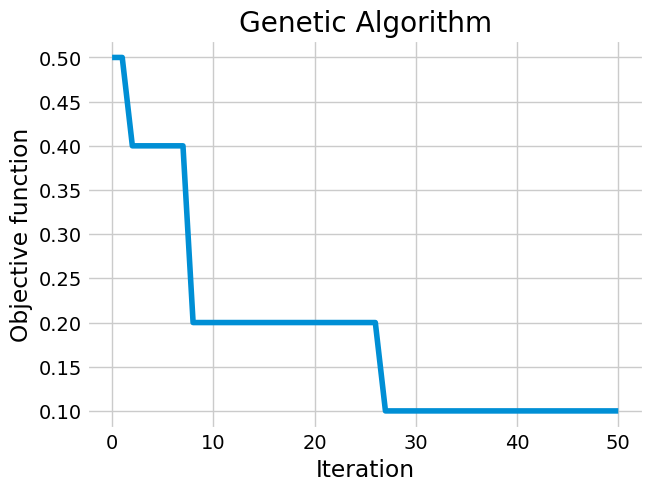

/tmp/ipykernel_2583/2233642108.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 25%|██▌       | 1/4 [32:58<1:38:56, 1978.84s/it]

Macro F1: 0.4240312828847004
F1 1: 0.7684605757196495
F1 -1: 0.07960199004975124
For number of layers: 4


/tmp/ipykernel_2583/2233642108.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.51598193 0.64611783 0.32933644 0.37856492 0.47335396 0.64463376
 0.15585043 0.44747105 0.30799201 0.25399439 0.81184292 0.46388339
 0.80820799 0.30406294 0.41420262 0.46660438 0.52740257 0.62124187
 0.75332187 0.25401731 0.86873811 0.64312665 0.47060477 0.10114733
 0.83966785 0.53608452 0.96369704 0.64225768 0.57046162 0.25526733
 0.73219408 0.2228494  0.99510033 0.80170943 0.76637141 0.41000458
 0.95921348]

 Objective function:
 0.0


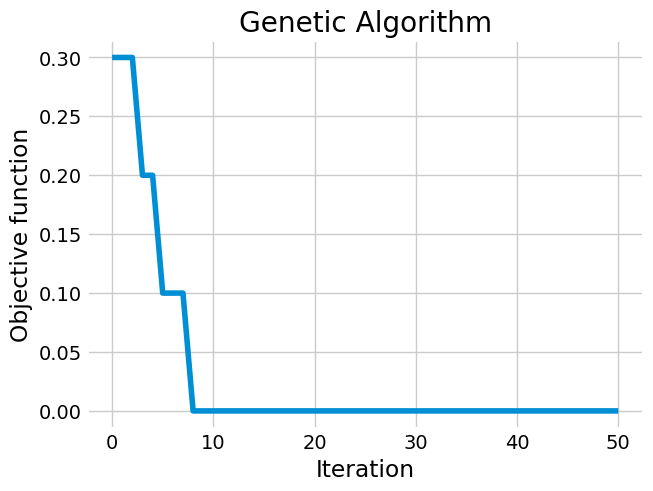

/tmp/ipykernel_2583/2233642108.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 50%|█████     | 2/4 [1:03:36<1:03:11, 1895.82s/it]

Macro F1: 0.2545255220727827
F1 1: 0.4446215139442231
F1 -1: 0.06442953020134227
For number of layers: 6


/tmp/ipykernel_2583/2233642108.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.95360349 0.59393216 0.26155444 0.66707114 0.04910333 0.38594497
 0.86555047 0.77680474 0.6050663  0.22140256 0.29403329 0.67844683
 0.55280608 0.75059502 0.15388374 0.16173623 0.76571395 0.48574078
 0.15485371 0.14844541 0.57678296 0.4541372  0.70878011 0.13143666
 0.82408777 0.20967348 0.3252232  0.67563909 0.7147505  0.06387083
 0.7404185  0.71279206 0.89144006 0.27379889 0.10871655 0.875708
 0.36926379 0.30346377 0.67823742 0.22038139 0.75697499 0.05754391
 0.13510013 0.91538463 0.65021647 0.61002269 0.97036836 0.34376941
 0.04170579 0.61935046 0.96024774 0.79472959 0.29953978 0.00411744
 0.44364324]

 Objective function:
 0.0


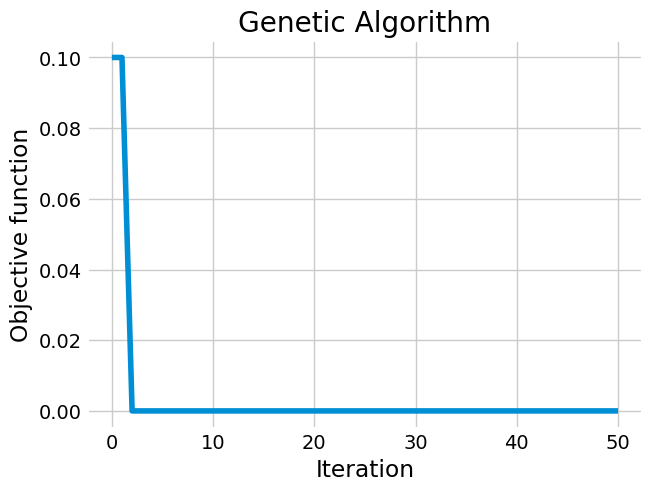

/tmp/ipykernel_2583/2233642108.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 75%|███████▌  | 3/4 [1:40:19<33:56, 2036.26s/it]  

Macro F1: 0.25865297674398674
F1 1: 0.44992050874403816
F1 -1: 0.06738544474393532
For number of layers: 8


/tmp/ipykernel_2583/2233642108.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.35277162 0.0866328  0.8358987  0.07214551 0.50118825 0.42428523
 0.03402936 0.69669316 0.65754887 0.06621965 0.44727738 0.59125198
 0.46325784 0.4373148  0.78706301 0.90092969 0.79220218 0.75187208
 0.17191069 0.43464869 0.93711646 0.09308736 0.0374763  0.4705933
 0.98831699 0.28327417 0.93587847 0.01234686 0.99106506 0.51460751
 0.59312868 0.57574098 0.82536532 0.44223496 0.39529757 0.42681166
 0.67428174 0.75123257 0.9687751  0.95505489 0.52348402 0.45341926
 0.23421932 0.14913524 0.44135865 0.657633   0.74102982 0.83678975
 0.50601695 0.06844303 0.92572936 0.10026925 0.65262264 0.41641829
 0.62708151 0.61969211 0.23339286 0.96545116 0.74134026 0.95686885
 0.26977682 0.84171279 0.45055918 0.43905015 0.00122273 0.92344963
 0.79356563 0.45051257 0.64227906 0.13356527 0.86438106 0.32106861
 0.31420093]

 Objective function:
 0.0


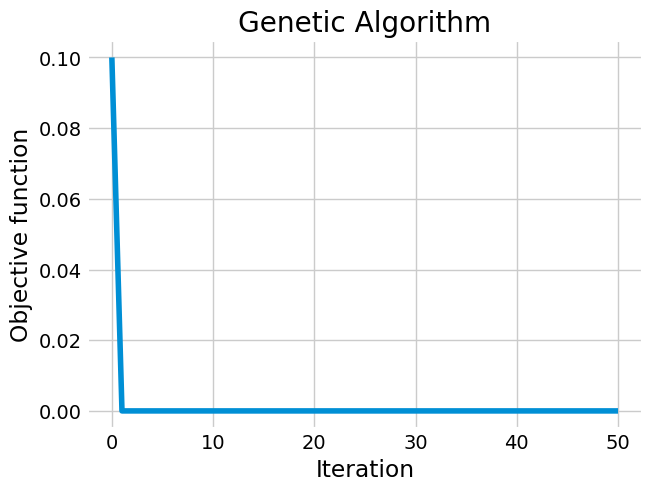

/tmp/ipykernel_2583/2233642108.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
100%|██████████| 4/4 [2:15:26<00:00, 2031.51s/it]

Macro F1: 0.29183745390551086
F1 1: 0.5163249810174639
F1 -1: 0.06734992679355783


In [22]:
for l in tqdm(range(2, 10, 2)):
    print("For number of layers: {}".format(l))
    encoded_X, num_qubits = data_encoding(X_vqc, "FRQI")
    vqocc = VQOCC(num_qubits=num_qubits,num_trash_qubits=1,layers=l)
    # Only input X with INLIER labels into VQC for training
    train_X = [encoded_X[i] for i in range(len(encoded_X)) if y_vqc[i] == 1]
    vqocc.train(train_X, lr=0.1, n_epochs=50, batch_size=10, verbose_loss=True)
    vqocc.test(encoded_X, y_vqc)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_23614/624811920.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


For number of layers: 2
 The best solution found:                                                                           
 [0.1014696  0.10069572 0.22165436 0.70515101 0.79882054 0.72043367
 0.76400009 0.70227177 0.06413309 0.87955545 0.99903674 0.53184484
 0.707408   0.24538565 0.01071166 0.96212003 0.79611594]

 Objective function:
 0.0


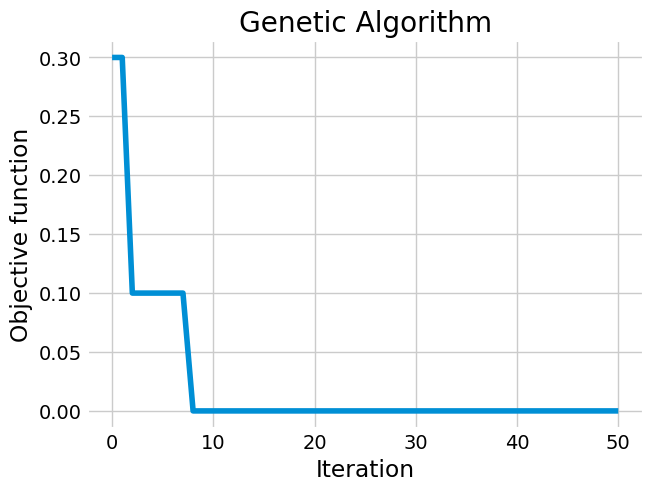

/tmp/ipykernel_23614/624811920.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 25%|██▌       | 1/4 [29:05<1:27:15, 1745.28s/it]

Macro F1: 0.26240507933207047
F1 1: 0.46671887235708703
F1 -1: 0.05809128630705394
For number of layers: 4


/tmp/ipykernel_23614/624811920.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.42703868 0.87897719 0.48547749 0.0699538  0.75873945 0.62967213
 0.60028362 0.31436896 0.26673235 0.52482556 0.49565538 0.40581066
 0.25507975 0.9308235  0.72689781 0.41948056 0.42856743 0.91585755
 0.47062497 0.46346929 0.48312641 0.71830274 0.86287219 0.06217646
 0.53852385 0.03928626 0.02114209 0.58599679 0.31753491 0.62693313
 0.81678723 0.38324332 0.86149585]

 Objective function:
 0.0


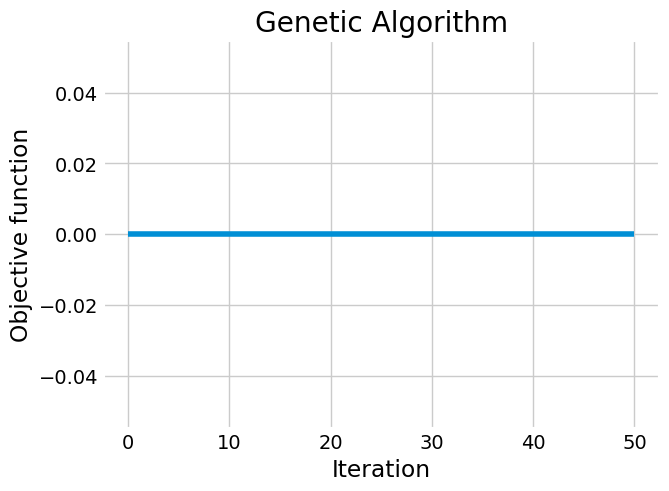

/tmp/ipykernel_23614/624811920.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 50%|█████     | 2/4 [58:48<58:54, 1767.46s/it]  

Macro F1: 0.3505469907626344
F1 1: 0.6460481099656358
F1 -1: 0.055045871559633024
For number of layers: 6


/tmp/ipykernel_23614/624811920.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.61555478 0.69223598 0.72791417 0.37321296 0.89304198 0.75896771
 0.95657358 0.48214368 0.71904496 0.3753976  0.96474039 0.75951983
 0.05692764 0.36804027 0.84743804 0.9813374  0.70328152 0.73910164
 0.15628474 0.06671407 0.84619887 0.7989824  0.65391106 0.5833095
 0.37375607 0.15182357 0.8358313  0.81140249 0.94893193 0.33517917
 0.84849161 0.36911174 0.43931142 0.53420836 0.61205558 0.89508624
 0.63937991 0.70547709 0.9403352  0.92147867 0.38648381 0.1155187
 0.0953146  0.03610525 0.33276545 0.12764312 0.55521247 0.80136674
 0.69164444]

 Objective function:
 0.0


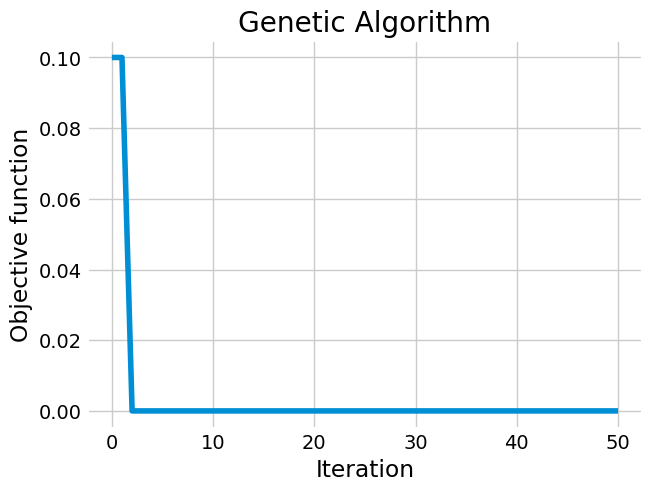

/tmp/ipykernel_23614/624811920.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
 75%|███████▌  | 3/4 [1:28:36<29:37, 1777.15s/it]

Macro F1: 0.30229092436291716
F1 1: 0.5381165919282512
F1 -1: 0.06646525679758308
For number of layers: 8


/tmp/ipykernel_23614/624811920.py:47: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [6.37398202e-02 2.43729582e-01 5.95737969e-01 9.06064162e-01
 7.34901148e-01 1.37032542e-01 1.82514517e-01 2.53565683e-01
 6.84988647e-01 8.24879969e-01 5.73363636e-01 4.10206370e-01
 4.93680634e-01 8.54500920e-02 9.29451730e-01 4.57640361e-01
 5.09611555e-02 6.94959398e-01 2.74914007e-01 3.00270356e-01
 1.87483311e-01 5.29218295e-01 2.92687800e-01 8.75831271e-01
 3.07442400e-01 5.01719643e-01 2.45266420e-01 5.99925263e-01
 6.26997024e-01 8.98574851e-01 8.69253963e-01 1.70858652e-01
 8.50153329e-01 5.52560552e-01 9.50187271e-01 7.16140276e-01
 2.35901329e-02 8.98940635e-01 1.16919511e-01 8.33107476e-01
 5.00164759e-01 8.93743111e-01 4.01751444e-01 2.35850566e-01
 8.07895231e-01 5.20282509e-01 8.87964435e-04 2.99279005e-01
 5.59568913e-01 9.57810075e-01 3.70023200e-01 2.23623742e-01
 5.41142322e-01 1.81339900e-01 3.89849639e-02 9.35354264e-01
 6.31518788e-01 2.30061890e-01 9.76908310e-0

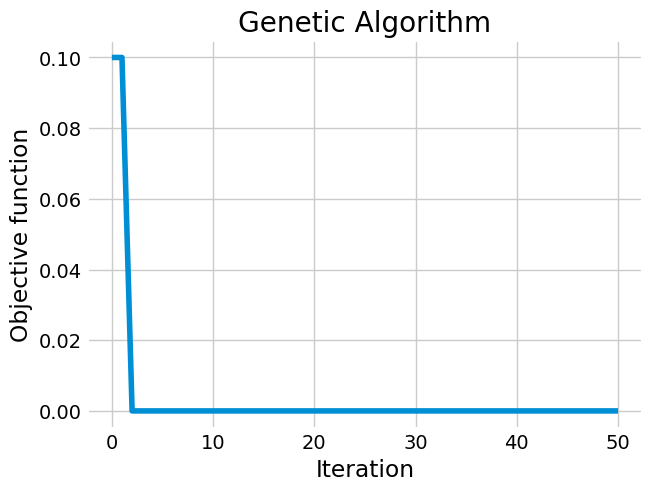

/tmp/ipykernel_23614/624811920.py:190: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy
100%|██████████| 4/4 [1:59:22<00:00, 1790.71s/it]

Macro F1: 0.17004870129870128
F1 1: 0.26964285714285713
F1 -1: 0.07045454545454544


In [43]:
for l in tqdm(range(2, 10, 2)):
    print("For number of layers: {}".format(l))
    encoded_X, num_qubits = data_encoding(X_vqc, "Amplitude")
    vqocc = VQOCC(num_qubits=num_qubits,num_trash_qubits=1,layers=l)
    # Only input X with INLIER labels into VQC for training
    train_X = [encoded_X[i] for i in range(len(encoded_X)) if y_vqc[i] == 1]
    vqocc.train(train_X, lr=0.1, n_epochs=50, batch_size=10, verbose_loss=True)
    vqocc.test(encoded_X, y_vqc)

## Comparison to classical one-class SVM methods

In [17]:
kernel_list = ['rbf', 'linear', 'poly', 'sigmoid']
supervised = False

classical_results = []

for kernel in kernel_list:
    svm_classical = OneClassSVM(kernel = kernel, verbose=True,  nu=outlier_fraction)
    print("{}:\n".format(kernel))

    if supervised:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
        svm_classical.fit(X_train, y_train)
        y_pred = svm_classical.predict(X_test)
        # TODO save to Matrix
        print("{}: ".format(kernel))
#             print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
        
        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))
        
        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
        
#             print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))
        
#             print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))

    else:
        svm_classical.fit(X)
        y_pred = svm_classical.predict(X_test)
        # TODO save to Matrix
        
#             print(classification_report(y, y_pred))
        # print("Accuracy: {}".format(accuracy_score(y, y_pred)))
        
        # print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        # print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
        # print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        f1 = f1_score(y_test, y_pred, average='macro')
        classical_results.append(f1)
        print("Macro F1: {}".format(f1))
#             print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))
        
#             print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

    print('---------------------------\n')

rbf:

[LibSVM]*
optimization finished, #iter = 89
obj = 65.388535, rho = 4.007559
nSV = 46, nBSV = 31
Macro F1: 0.4845360824742268
---------------------------

linear:

[LibSVM]*
optimization finished, #iter = 12
obj = -0.000001, rho = -0.000022
nSV = 43, nBSV = 34
Macro F1: 0.4897959183673469
---------------------------

poly:

[LibSVM]*......
*
optimization finished, #iter = 6924
obj = 0.001300, rho = 0.000295
nSV = 55, nBSV = 29
Macro F1: 0.2145514675485738
---------------------------

sigmoid:

[LibSVM]*
optimization finished, #iter = 57
obj = -129.543514, rho = -6.198608
nSV = 38, nBSV = 36
Macro F1: 0.49238578680203043
---------------------------



# Plotting results

Macro F1 results when running classical training and testing on same sets as quantum training and testing:

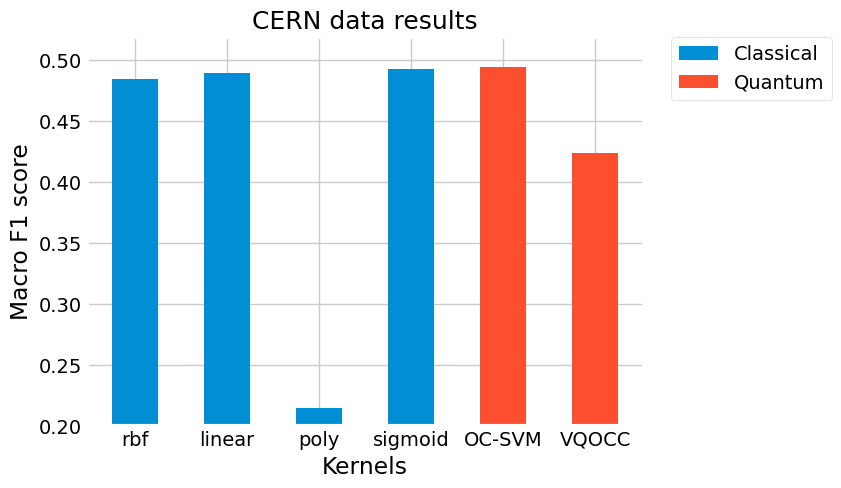

In [18]:
# stored above, or manually here:
#classical_results = [0.4845, 0.4897, 0.2145, 0.4923]

#plt.figure(figsize=(3, 3))

# bars for classical:
plt.bar(kernel_list, classical_results, label='Classical', width=0.5)

# bars for quantum:
plt.bar(['OC-SVM', 'VQOCC'], [0.4945, 0.4240], label='Quantum', width=0.5)


plt.ylim(0.2)
plt.xlabel('Kernels')
plt.ylabel('Macro F1 score')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
# Title added in latex
#plt.title('CERN data results \n Trained with 1000 samples, tested on 100 samples')
plt.title('CERN data results', fontsize=18)
plt.show()

Macro F1 results when running classical on the full CERN data and testing on the full CERN data:

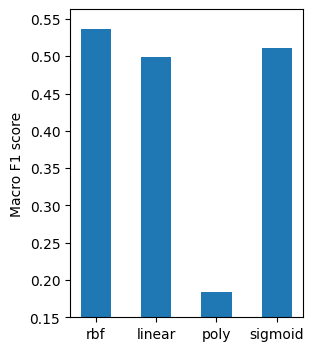

In [73]:
classical_full_results = [0.5362, 0.4984, 0.1840, 0.5108]
#x_pos = [1/4, 2/4, 3/4, 4/4]

plt.figure(figsize=(3, 4))
plt.bar(kernel_list, classical_full_results, label='Classical', width=0.5)
plt.ylim(0.15)
plt.ylabel('Macro F1 score')
#plt.xticks(x_pos, kernel_list)
plt.show()

## Algorithm 2 results



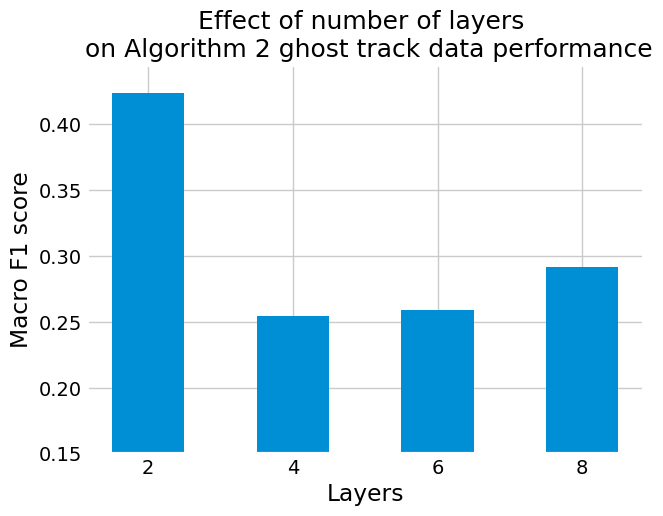

In [30]:
alg2_results = [0.4240312828847004, 0.2545255220727827, 0.25865297674398674, 0.29183745390551086]

#plt.figure(figsize=(3, 4))
plt.bar(range(4), alg2_results, width=0.5)
plt.ylim(0.15)
plt.ylabel('Macro F1 score')
plt.xlabel('Layers')
plt.xticks(range(4), [2,4,6,8])
plt.title('Effect of number of layers \n on Algorithm 2 ghost track data performance', fontsize=18)
plt.show()

# Appendix: Assessing the quality of other features

This would be due-diligence that can be done if there is still time.

In [17]:
full_cern_data

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z,chi2/dof
0,37.042889,1,2.744781,29,22,0.000093,-0.032356,-0.026533,0.032351,-0.039451,2.051071,1.683768
1,12.333838,1,505.177429,21,6,-0.000100,-0.020835,-0.022025,-1.026810,0.971350,124.333954,2.055640
2,11.791684,1,1.248908,24,12,0.000113,-0.008289,-0.035582,-0.032666,0.007609,84.878311,0.982640
3,22.339798,1,3893.681641,26,16,-0.000053,-0.004296,-0.019615,0.003717,-0.000814,-109.656128,1.396237
4,19.041876,1,2.024810,25,14,0.000094,-0.007948,-0.046065,0.069844,-0.012051,84.299057,1.360134
...,...,...,...,...,...,...,...,...,...,...,...,...
18320,21.877516,1,1.353087,31,26,-0.000246,-0.003892,0.094137,-0.010576,-0.000436,-133.640045,0.841443
18321,17.455692,1,0.945140,22,8,-0.000223,-0.170432,-0.096830,0.027389,-0.048208,94.859215,2.181962
18322,2.377720,1,1.130440,20,6,-0.000157,-0.092891,-0.061437,0.007144,-0.010802,94.624451,0.396287
18323,7.393714,1,10.609664,26,18,-0.000206,0.122870,-0.017398,0.016633,0.117464,-32.473801,0.410762
